In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download najiaboo/indiancurrency-for-classification

Dataset URL: https://www.kaggle.com/datasets/najiaboo/indiancurrency-for-classification
License(s): unknown
100% 255M/255M [00:14<00:00, 17.1MB/s]
100% 255M/255M [00:14<00:00, 18.1MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/indiancurrency-for-classification.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import torch
from torch.utils.data import dataloader
from torchvision import models, datasets, transforms


import numpy as np
import os
import time


In [ ]:
path ='/content/IndianCurrency_classification'
path_folder = ['/content/IndianCurrency_classification/train','/content/IndianCurrency_classification/val']

transformers = {path_folder[0]: transforms.Compose([transforms.RandomResizedCrop(224),\
    transforms.RandomHorizontalFlip(),#transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),\
    path_folder[1]:transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),\
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
    }

In [ ]:
image_dataset = {x: datasets.ImageFolder(os.path.join(path,x), transformers[x] )\
    for x in path_folder
    }

image_dataloaders = {x: dataloader.DataLoader(image_dataset[x], batch_size=64,num_workers=os.cpu_count(), shuffle=True )
    for x in path_folder
    }

dataset_size = {x: len(image_dataset[x]) for x in path_folder}

class_names = image_dataset[path_folder[0]].classes

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Train Function


In [ ]:
import torch
import copy
import time


def train(model, optimizer: torch.optim, loss_fn, device, dataloader, dataset_size, epochs=2):

    since = time.time()
    best_wt = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):

        print(f"epoch {epoch}/{epochs-1}")
        print('-' * 10)

        for phase in [path_folder[0], path_folder[1]]:

            if phase == path_folder[0]:
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, target in dataloader[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == path_folder[0]):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, target)

                    if phase == path_folder[0]:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == target.data)
                # print(f"running loss : {running_loss}")

            if phase == path_folder[0]:
                pass
                # scheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            # running_corrects = running_corrects * 1.0
            epoch_accuracy = running_corrects.item() / (dataset_size[phase] * 1.0)

            print(f"{phase}, Loss:{epoch_loss:.4f}, acc: {epoch_accuracy:.4f}")

            if phase == path_folder[1] and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_wt = copy.deepcopy(model.state_dict())
                # Save the model to the current working directory
                torch.save(model.state_dict(), "final.pt")
        print()

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_wt)
    # Save the model to the current working directory
    torch.save(model.state_dict(), "final.pt")

    return model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


# def demo():
#     plt.plot([1,2,3,4],[1,4,9,16])
#     plt.ylabel('y numbers')
#     plt.xlabel('x numbers')
#     plt.show()

def visualize_model(model,dataloaders,device,class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[path_folder[1]]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)


            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print("*"*10)
                print(j)
                print(preds)
                print(preds[j])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(10)


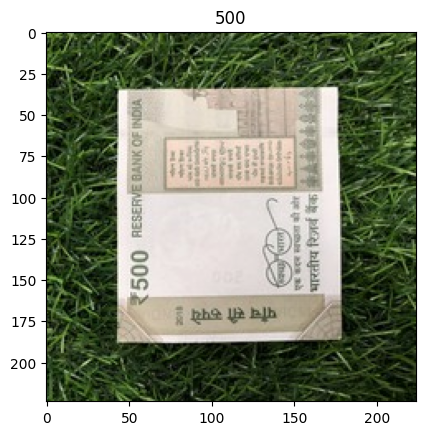

In [ ]:
# Get a batch of images and labels from the dataloader
inputs, labels = next(iter(image_dataloaders[path_folder[1]]))

# Display the first image in the batch
imshow(inputs[0], title=class_names[labels[0]])

#Implementing the model

In [ ]:
from torch import device, optim
import torch.nn as nn
import torchvision


from torch.optim import lr_scheduler



model_conv = torchvision.models.resnet18(pretrained=True)


for param in model_conv.parameters():
        param.requires_grad = False

for param in model_conv.fc.parameters():
        param.requires_grad = True

num_ftrs = model_conv.fc.in_features

# define the network head and attach it to the model
headModel = nn.Sequential(
	nn.Linear(num_ftrs, 512),
	nn.ReLU(),
	nn.Dropout(0.25),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Dropout(0.5),
 	nn.Linear(256, 128),
  	nn.ReLU(),
   	nn.Dropout(0.5),
   	nn.Linear(128, 64),
    nn.ReLU(),
	nn.Linear(64, 7)
)

model_conv.fc = headModel

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model_conv = model_conv.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)


model_ft = train(model_conv,optimizer_conv, loss_fn, device, image_dataloaders, dataset_size,epochs=100 )





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


epoch 0/99
----------
/content/IndianCurrency_classification/train, Loss:1.8820, acc: 0.2159
/content/IndianCurrency_classification/val, Loss:1.8016, acc: 0.2863

epoch 1/99
----------
/content/IndianCurrency_classification/train, Loss:1.6777, acc: 0.2945
/content/IndianCurrency_classification/val, Loss:1.3385, acc: 0.4288

epoch 2/99
----------
/content/IndianCurrency_classification/train, Loss:1.3179, acc: 0.4512
/content/IndianCurrency_classification/val, Loss:1.1626, acc: 0.5251

epoch 3/99
----------
/content/IndianCurrency_classification/train, Loss:1.1876, acc: 0.5175
/content/IndianCurrency_classification/val, Loss:0.9244, acc: 0.6285

epoch 4/99
----------
/content/IndianCurrency_classification/train, Loss:1.0134, acc: 0.6108
/content/IndianCurrency_classification/val, Loss:0.8291, acc: 0.7067

epoch 5/99
----------
/content/IndianCurrency_classification/train, Loss:0.8948, acc: 0.6624
/content/IndianCurrency_classification/val, Loss:0.8028, acc: 0.7011

epoch 6/99
----------


#Evaluate the model for testing data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def predict(model, dataloader, device):
     model.eval()
     predictions = []
     true_labels = []
     probabilities = [] # Store predicted probabilities

     with torch.no_grad():
         for inputs, labels in dataloader[path_folder[1]]:
             inputs = inputs.to(device)
             labels = labels.to(device)

             outputs = model(inputs)
             _, preds = torch.max(outputs, 1)
             probs = torch.nn.functional.softmax(outputs, dim=1) # Calculate probabilities

             predictions.extend(preds.cpu().numpy())
             true_labels.extend(labels.cpu().numpy())
             probabilities.extend(probs.cpu().numpy())

     return predictions, true_labels, probabilities

In [ ]:
predictions, true_labels, probabilities = predict(model_ft, image_dataloaders, device)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted') # Use weighted average for multi-class
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9302
Precision: 0.9345
Recall: 0.9302
F1-score: 0.9307


**********
0
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(3, device='cuda:0')


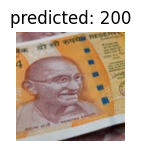

**********
1
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(0, device='cuda:0')


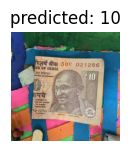

**********
2
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(0, device='cuda:0')


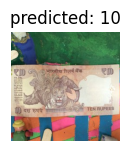

**********
3
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(4, device='cuda:0')


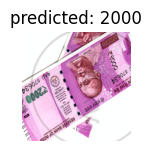

**********
4
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(1, device='cuda:0')


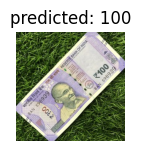

**********
5
tensor([3, 0, 0, 4, 1, 2, 2, 1, 5, 1, 4, 1, 4, 2, 5, 1, 5, 3, 6, 1, 6, 6, 1, 2,
        4, 5, 1, 2, 0, 3, 5, 0, 0, 6, 0, 0, 2, 0, 3, 4, 3, 5, 4, 0, 0, 0, 0, 1,
        0, 1, 2, 4, 6, 5, 6, 4, 4, 0, 2, 5, 0, 6, 0, 5], device='cuda:0')
tensor(2, device='cuda:0')


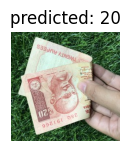

In [ ]:
visualize_model(model_ft,image_dataloaders,device,class_names, num_images=6)

In [ ]:
print("Predictions:", predictions[0:10])
print("True Labels:", true_labels[0:10])

Predictions: [5, 1, 0, 0, 6, 5, 0, 3, 5, 2]
True Labels: [5, 1, 0, 0, 6, 5, 0, 3, 5, 2]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
cm = confusion_matrix(true_labels, predictions)

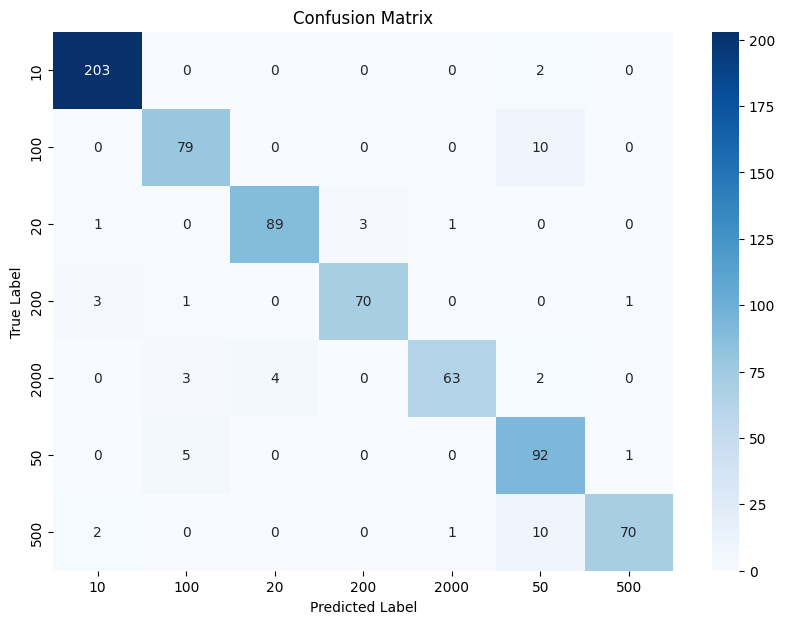

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

              precision    recall  f1-score   support

          10       0.97      0.99      0.98       205
         100       0.90      0.89      0.89        89
          20       0.96      0.95      0.95        94
         200       0.96      0.93      0.95        75
        2000       0.97      0.88      0.92        72
          50       0.79      0.94      0.86        98
         500       0.97      0.84      0.90        83

    accuracy                           0.93       716
   macro avg       0.93      0.92      0.92       716
weighted avg       0.93      0.93      0.93       716

